In [4]:
import json
import jsmin
from lussac.core import LussacData
import pathlib
import platform
import spikeinterface.core as si
import numpy as np
import matplotlib.pyplot as plt
from python_code.nord_cmap import *
from tqdm import tqdm
from typing import Callable, Iterable
from spikeinterface.preprocessing import filter_gaussian
import os
import pickle

In [2]:
def load_json(filename: str) -> dict:
	"""
	Loads the JSON parameters file and returns its content.

	@param filename: str
		Path to the file containing Lussac's parameters.
	@return params: dict
		Lussac's parameters.
	"""
	folder = pathlib.Path(filename).parent
	with open(filename) as json_file:
		minified = jsmin.jsmin(json_file.read())  # Parses out comments.
		minified = minified.replace("$PARAMS_FOLDER", str(folder.absolute()))
		print(folder.absolute())
		if platform.system() == "Windows":  # pragma: no cover (OS specific).
			minified = minified.replace("\\", "\\\\")

		return json.loads(minified)

In [10]:
params = load_json('/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/lussac_params.json')
data = LussacData.create_from_params(params)

/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses
{'ks2_default': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_default/in_container_sorting/provenance.json', 'ks2_pj8-3': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_pj8-3/in_container_sorting/provenance.json', 'ks2_pj6-2.5': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_pj6-2.5/in_container_sorting/provenance.json', 'ks2_5_default': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_5_default/in_container_sorting/provenance.json', 'ks2_5_pj7-3': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_5_pj7-3/in_container_sorting/provenance.json', 'ks3_default': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks3_default/in_container_sorting/provenance.json', 'ks3_pj7-3': '/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks3_pj7-3/in_container_sorting/provenance.json', 'sc_default': '/media/

/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_pj6-2.5/in_container_sorting/provenance.json


/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_5_default/in_container_sorting/provenance.json


/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks2_5_pj7-3/in_container_sorting/provenance.json


/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks3_default/in_container_sorting/provenance.json


/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ks3_pj7-3/in_container_sorting/provenance.json


/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/sc_default/in_container_sorting/provenance.json


/home/andrea/anaconda3/lib/python3.11/site-packages/spikeinterface/core/base.py:1069: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.99.0.dev0 is recommended



/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/ms5_default/in_container_sorting/provenance.json

Running Lussac!



In [2]:
path_analyses = "/media/andrea/Crucial X6/synthetic_MEArec/1h_3000cells/analyses/"


In [5]:
from lussac.core import TemplateExtractor
import spikeinterface.qualitymetrics as sq
import pandas as pd
from spikeinterface.postprocessing import compute_spike_amplitudes

In [4]:
list_metrics = sq.get_quality_metric_list()
list_metrics.remove('drift')

In [33]:
list_metrics

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'snr',
 'isi_violation',
 'rp_violation',
 'sliding_rp_violation',
 'amplitude_cutoff',
 'amplitude_median',
 'amplitude_cv',
 'synchrony',
 'firing_range',
 'sd_ratio']

In [29]:
def extract_metrics(cache_folder : str, analyse : str) : 
    
  path = pathlib.Path(path_analyses + analyse + '/sorter_output')
  recording, sorting = data.recording, data.sortings[analyse]
  template_extract = TemplateExtractor(recording, sorting , path )

  template_extract.set_params()

  params = {
              'ms_before': template_extract.params['ms_before'],
              'ms_after': template_extract.params['ms_after'],
              'max_spikes_per_unit': template_extract.params['max_spikes_sparsity'],
              'precompute_template': ("average", ),
              'return_scaled': False,
              'allow_unfiltered': True
  }
  if not (os.path.exists(cache_folder)):
    
    si.extract_waveforms(recording, sorting, cache_folder, mode="folder", n_jobs=4, **params, progress_bar = True, overwrite = True,)
    
  we = si.load_waveforms(folder = cache_folder)
  compute_spike_amplitudes(we, load_if_exists= True, n_jobs=4)
  return sq.compute_quality_metrics(waveform_extractor=we, metric_names= list_metrics)

In [ ]:
analyses_metrics = pd.DataFrame()

for analyse in params['analyses'].keys() : 
    
    print('procesing ... : ' + analyse + ' analyse')
    
    metrics = extract_metrics('waveform_folder_parallel', analyse)
    metrics.assign(analyse = analyse).set_index('analyse', append = True)
    
    analyses_metrics = pd.concat([analyses_metrics, metrics])

In [25]:
analyses_metrics = pd.read_pickle("/media/andrea/Crucial X6/Master/IMEX/codes/data_nodes.pkl")

In [26]:
analyses_metrics['score_aur'] = analyses_metrics['firing_rate'] * (1 - 2 * analyses_metrics['rp_contamination']) 

In [27]:
analyses_metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,sync_spike_2,sync_spike_4,sync_spike_8,score_aur
0,15687.0,4.357500,1.0,2.805877,0.000000,0.0,0.000000,0.0,0.010,NaN,17.5,0.065596,0.000000,0.0,4.357500
1,38137.0,10.593611,1.0,11.535462,0.000000,0.0,0.000000,0.0,0.005,NaN,70.0,0.071532,0.000026,0.0,10.593611
2,14908.0,4.141111,1.0,11.112219,0.005399,1.0,0.008132,1.0,0.020,NaN,66.0,0.072847,0.000134,0.0,4.073759
3,22085.0,6.134722,1.0,11.877765,0.000000,0.0,0.000000,0.0,0.005,NaN,103.0,0.074394,0.000136,0.0,6.134722
4,26491.0,7.358611,1.0,3.491609,0.006840,4.0,0.010313,4.0,0.015,NaN,31.0,0.066362,0.000075,0.0,7.206834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,17001.0,4.722500,1.0,4.813608,0.000000,0.0,0.000000,0.0,0.010,NaN,42.0,0.026998,0.000000,0.0,4.722500
242,22419.0,6.227500,1.0,3.954758,0.000000,0.0,0.000000,0.0,0.010,NaN,35.0,0.028101,0.000000,0.0,6.227500
243,58043.0,16.123056,1.0,4.507840,0.000000,0.0,0.000000,0.0,0.005,NaN,39.5,0.027325,0.000000,0.0,16.123056
244,9906.0,2.751667,1.0,4.221182,0.000000,0.0,0.000000,0.0,0.025,NaN,36.0,0.032405,0.000000,0.0,2.751667


In [31]:
corr = analyses_metrics.corr(method= 'pearson')

In [32]:
corr = corr.round(2).stack().reset_index(name="correlation")


In [33]:
corr

,level_0,level_1,correlation
0,num_spikes,num_spikes,1.00
1,num_spikes,firing_rate,1.00
2,num_spikes,presence_ratio,0.14
3,num_spikes,snr,-0.15
4,num_spikes,isi_violations_ratio,-0.04
...,...,...,...
162,score_aur,sliding_rp_violation,-0.27
163,score_aur,amplitude_median,-0.02
164,score_aur,sync_spike_2,-0.01
165,score_aur,sync_spike_4,-0.03


/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprec

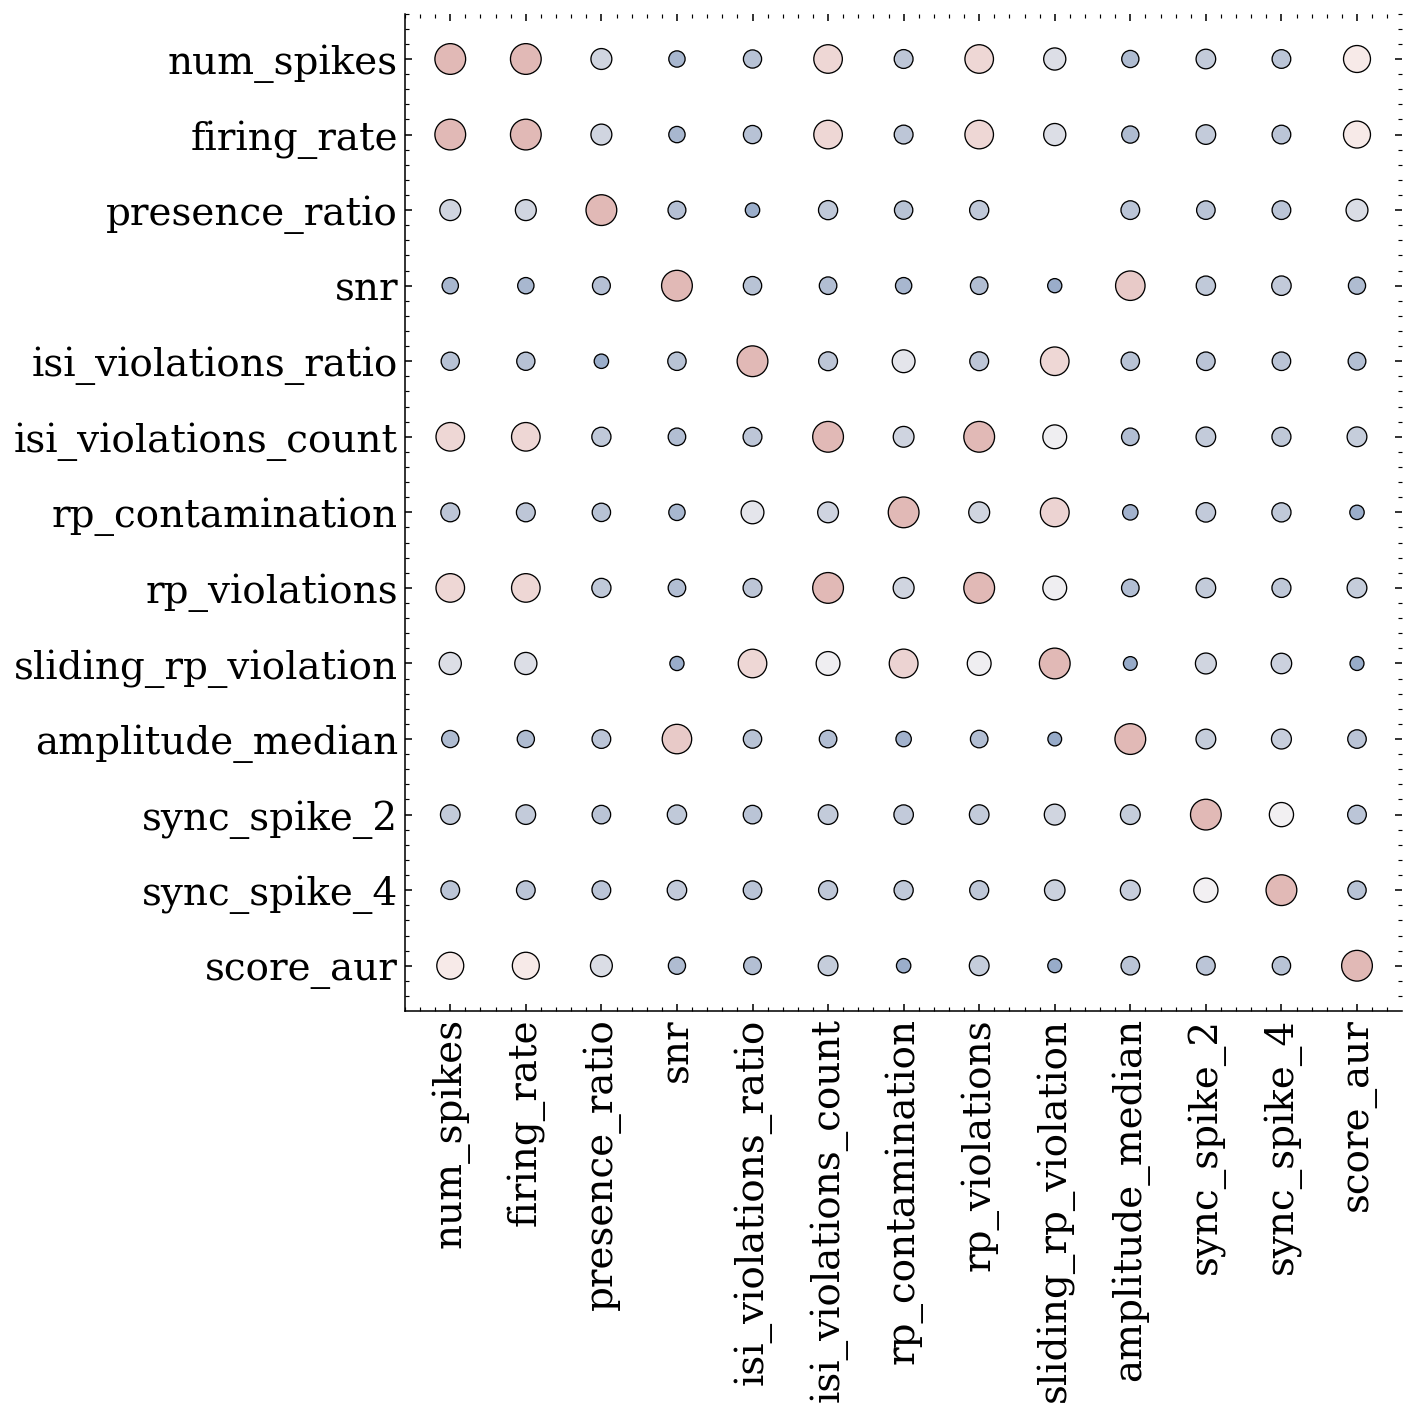

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(
    data=corr,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 2), edgecolor="0", sizes=(50, 250), legend = False, aspect=1, height=10)
plt.xlabel('')
plt.ylabel('')

plt.xticks(rotation=90, fontsize = 20)
plt.yticks(rotation=0, fontsize = 20)
plt.savefig('../CR/figure/correlation.png', dpi = 300)


In [25]:
analyses_metrics.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410],
      dtype='int64', length=3690)

In [26]:
analyses_metrics_2.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       236, 237, 238, 239, 240, 241, 242, 243, 244, 245],
      dtype='int64', length=3569)

In [8]:
analyses_metrics.to_pickle("data_nodes.pkl")

In [20]:
analyses_metrics_2 = pd.read_pickle("data_nodes.pkl")

In [22]:
analyses_metrics_2

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,sync_spike_2,sync_spike_4,sync_spike_8
0,15687.0,4.357500,1.0,2.805877,0.000000,0.0,0.000000,0.0,0.010,NaN,17.5,0.065596,0.000000,0.0
1,38137.0,10.593611,1.0,11.535462,0.000000,0.0,0.000000,0.0,0.005,NaN,70.0,0.071532,0.000026,0.0
2,14908.0,4.141111,1.0,11.112219,0.005399,1.0,0.008132,1.0,0.020,NaN,66.0,0.072847,0.000134,0.0
3,22085.0,6.134722,1.0,11.877765,0.000000,0.0,0.000000,0.0,0.005,NaN,103.0,0.074394,0.000136,0.0
4,26491.0,7.358611,1.0,3.491609,0.006840,4.0,0.010313,4.0,0.015,NaN,31.0,0.066362,0.000075,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,17001.0,4.722500,1.0,4.813608,0.000000,0.0,0.000000,0.0,0.010,NaN,42.0,0.026998,0.000000,0.0
242,22419.0,6.227500,1.0,3.954758,0.000000,0.0,0.000000,0.0,0.010,NaN,35.0,0.028101,0.000000,0.0
243,58043.0,16.123056,1.0,4.507840,0.000000,0.0,0.000000,0.0,0.005,NaN,39.5,0.027325,0.000000,0.0
244,9906.0,2.751667,1.0,4.221182,0.000000,0.0,0.000000,0.0,0.025,NaN,36.0,0.032405,0.000000,0.0


TypeError: 'Index' object is not callable

In [25]:
analyses_metrics.iloc[4]

num_spikes              26491.000000
firing_rate                 7.358611
presence_ratio              1.000000
snr                         3.491609
isi_violations_ratio        0.006840
isi_violations_count        4.000000
rp_contamination            0.010313
rp_violations               4.000000
sliding_rp_violation        0.015000
amplitude_cutoff                 NaN
amplitude_median           31.000000
sync_spike_2                0.066362
sync_spike_4                0.000075
sync_spike_8                0.000000
Name: 4, dtype: float64